In [5]:
# load all libraries
import numpy as np
import pandas as pd
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    roc_curve,
    classification_report,
)
from sklearn.model_selection import (
    KFold,
    GridSearchCV,
    train_test_split,
    RandomizedSearchCV,
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
)
from scipy.stats import uniform, randint
from sklearn.compose import ColumnTransformer
import time
import joblib
import seaborn as sns
from sklearn.svm import SVC
import warnings

warnings.filterwarnings("ignore")

## Quick Summary:

- [1. Loading data & Cleaning](#1-loading-data--cleaning)
    - [1.1 Loading ready-for-model dataset](#1-loading-data--cleaning)
    - [1.2 Cleaning, train-test splitting](#12-cleaning-train-test-splitting)

- [2. Classification Model Training ](#2-classification-model-training)
    - [2.1 Training all models](#21-training-all-models)
        - [2.1.1 Baseline - Logistic Regression](#211-baseline---logistic-regression)
        - [2.1.2 SVM Classifier](#212-svm-classifier)
        - [2.1.3 Decision Tree](#213-decision-tree) 
        - [2.1.4 Random Forest](#214-random-forest)
        - [2.1.5 Gradient Boosting](#215-gradient-boosting) 

        
    - [2.2 Comparison of Classifiers](#22-comparison-of-classifiers)
        - [2.2.1 Comparison Table](#221-comparison-table)
        - [2.2.2 Comparison ROC curve](#222-comparison-roc-curve)
- [3. Model extraction](#3-model-extraction)

Important things to keep in mind:
- False Positive is more dangerous, because it will defect your software and crash. 
- we can add lightweight classifier later to see how likely is the maintainers username is spam_likely - improve the main ML model. Maintainers likely to create username in pattern.

## 1. Loading data & Cleaning
#### 1.1 Loading ready-for-model dataset

In [6]:
from feature_engineering.load_data import load_json

df = load_json("../data/20251207-bq-results-with-mid-pkgs.jsonl", lines=True)
pd.set_option("display.max_columns", None)
df.info()

Index(['pkg_name', 'n_name_len', 'has_digit_in_name', 'has_dash_or_underscore',
       'cat_name_case', 'n_summary_len', 'n_desc_len', 'n_desc_lines',
       'has_code_block_in_desc', 'n_urls_in_desc', 'has_suspicious_kw',
       'pct_non_ascii_desc', 't_age_first_release_days',
       't_age_last_release_days', 'n_versions', 't_median_release_gap_days',
       'has_single_release', 'cat_weekday_of_last_release', 'n_maintainers',
       'pct_free_email_domains', 'has_disposable_email', 'has_missing_author',
       'has_homepage', 'has_repo_url', 'cat_repo_host', 'has_issue_tracker',
       'has_docs_url', 'has_license', 'cat_license_family', 'n_classifiers',
       'has_prog_lang_classifier', 'has_typing_classifier', 'n_distributions',
       'n_requires', 'has_extras', 'n_downloads_7d', 'n_downloads_30d',
       'n_dependents_est', 'rule_no_repo_low_desc_len',
       'rule_suspicious_name_and_dep', 'is_spam', 'n_lev_dist_to_top1',
       'n_lev_dist_to_alias', 'sim_tfidf_to_legit_cent

#### 1.2 Cleaning, train-test splitting
[Click here to go to 'Quick Summary'](#quick-summary)

In [7]:
# X, y variables
drop_cols = ["pkg_name", "is_spam"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
y = df["is_spam"].astype(int)

# seperating categorical and numerical columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# for col in categorical_cols:
#     print(col, X[col].unique())

# dummy encoding the dataset
preprocessor = ColumnTransformer(
    transformers=[
        (
            "cat",
            OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"),
            categorical_cols,
        )
    ],
    remainder="passthrough",
)

# ----------------------------------------------------
# train-test split
# ----------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# encoding cat values:
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)
# Get the new feature names (encoded categories + passed-through numerical columns)
feature_names_out = preprocessor.get_feature_names_out().tolist()

# Convert the NumPy arrays back to DataFrames
X_train_encoded_df = pd.DataFrame(
    X_train_encoded, columns=feature_names_out, index=X_train.index
)
X_test_encoded_df = pd.DataFrame(
    X_test_encoded, columns=feature_names_out, index=X_test.index
)
scaler = StandardScaler().fit(X_train_encoded_df)
X_train_encoded_df = scaler.transform(X_train_encoded_df)
X_test_encoded_df = scaler.transform(X_test_encoded_df)

X_train_const = add_constant(X_train_encoded_df, has_constant="add")
X_test_const = add_constant(X_test_encoded_df, has_constant="add")
print(X_train_const.shape, X_test_const.shape)

(12469, 66) (3118, 66)


# 2. Classification Model Training
### 2.1 Training all models

##### 2.1.1 Baseline - Logistic Regression

[Click here to go to 'Quick Summary'](#quick-summary)

In [8]:
# ----------------------------------------------------
# 2.1.1. Logistic Regression
# --------------------------------------------------
# fit the regression:
print("\n--- Model Evaluation (Logistic Regression) ---")
log_reg_base = LogisticRegression()
log_reg_base.fit(X_train_const, y_train)
y_train_pred_log = log_reg_base.predict(X_train_const)
y_test_pred_log = log_reg_base.predict(X_test_const)

# Evaluate the model
train_accuracy_log = accuracy_score(y_train, y_train_pred_log)
test_accuracy_log = accuracy_score(y_test, y_test_pred_log)
print(f"Training Accuracy: {train_accuracy_log:.4f}")
print(f"Testing Accuracy: {test_accuracy_log:.4f}")

print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_test_pred_log))
# ROC and AUC:
fpr_log, tpr_log, thresh_log = roc_curve(y_test, y_test_pred_log)
auc_log = roc_auc_score(y_test, y_test_pred_log)



--- Model Evaluation (Logistic Regression) ---
Training Accuracy: 0.9891
Testing Accuracy: 0.9865

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       945
           1       0.99      0.99      0.99      2173

    accuracy                           0.99      3118
   macro avg       0.98      0.98      0.98      3118
weighted avg       0.99      0.99      0.99      3118



##### 2.1.2 SVM Classifier

[Click here to go to 'Quick Summary'](#quick-summary)

In [9]:
# ----------------------------------------------------
# 2.1.2. Initialize the SVM Model - linear kernel
# --------------------------------------------------
# 1. Initialize the SVM model
svm_model = SVC(kernel="linear", C=1.0, random_state=42)

# 2. Fit the SVM model
# used the encoded data WITHOUT the added constant, as SVC handles the intercept.
svm_model.fit(X_train_encoded_df, y_train)

# 3. Predict on Training and Testing Sets
y_train_pred_svm = svm_model.predict(X_train_encoded_df)
y_test_pred_svm = svm_model.predict(X_test_encoded_df)

# 4. Evaluate the model
print("\n--- Model Evaluation (Support Vector Machine) ---")

train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
print(f"Training Accuracy: {train_accuracy_svm:.4f}")
print(f"Testing Accuracy: {test_accuracy_svm:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_svm))
# ROC and AUC:
fpr_svm, tpr_svm, thresh_svm = roc_curve(y_test, y_test_pred_svm)
auc_svm = roc_auc_score(y_test, y_test_pred_svm)


--- Model Evaluation (Support Vector Machine) ---
Training Accuracy: 0.9910
Testing Accuracy: 0.9904

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       945
           1       0.99      0.99      0.99      2173

    accuracy                           0.99      3118
   macro avg       0.99      0.99      0.99      3118
weighted avg       0.99      0.99      0.99      3118



##### 2.1.3 Decision Tree
[Click here to go to 'Quick Summary'](#quick-summary)

In [10]:
# ----------------------------------------------------
# 2.1.3. CART
# --------------------------------------------------
grid_values = {
    "ccp_alpha": np.linspace(0, 0.10, 201),
    "min_samples_leaf": [5],
    "min_samples_split": [20],
    "max_depth": [30],
    "random_state": [88],
}


dtc = DecisionTreeClassifier()
dtc_cv_acc = GridSearchCV(
    dtc, param_grid=grid_values, scoring="accuracy", cv=10, verbose=1
)  # default scoring metric to optimize is accuracy, used as default if none given.
dtc_cv_acc.fit(X_train_const, y_train)


Fitting 10 folds for each of 201 candidates, totalling 2010 fits


,estimator,DecisionTreeClassifier()
,param_grid,"{'ccp_alpha': array([0. ... 0.1 ]), 'max_depth': [30], 'min_samples_leaf': [5], 'min_samples_split': [20], ...}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [11]:
# --- 1. Retrieve the Best Model ---
# The best_estimator_ attribute holds the final, trained model with the optimal parameters.
dtc_best_model = dtc_cv_acc.best_estimator_

# Print the best parameters found by GridSearchCV for verification
print("Best parameters found:")
print(dtc_cv_acc.best_params_)
print(
    "Grid best parameter ccp_alpha (max. accuracy): ",
    dtc_cv_acc.best_params_["ccp_alpha"],
)
print("Grid best score (accuracy): ", dtc_cv_acc.best_score_)
# --- 2. Make Predictions ---
# Predict classes (0 or 1)
y_train_pred_dtc = dtc_best_model.predict(X_train_const)
y_test_pred_dtc = dtc_best_model.predict(X_test_const)

# Predict probabilities for ROC/AUC (optional, but often better than raw classes for AUC)
# We assume the Decision Tree classifier supports predict_proba.
try:
    y_test_proba_dtc = dtc_best_model.predict_proba(X_test_const)[:, 1]
except AttributeError:
    # Fallback if predict_proba is not available, though it should be for DTC
    y_test_proba_dtc = y_test_pred_dtc


# ---  Evaluation ---
print("\n--- Model Evaluation (Decision Tree Classifier) ---")
# Compute Accuracy
train_accuracy_dtc = accuracy_score(y_train, y_train_pred_dtc)
test_accuracy_dtc = accuracy_score(y_test, y_test_pred_dtc)
print(f"Training Accuracy: {train_accuracy_dtc:.4f}")
print(f"Testing Accuracy: {test_accuracy_dtc:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_dtc))
# Compute ROC and AUC
fpr_dtc, tpr_dtc, thresh_dtc = roc_curve(y_test, y_test_proba_dtc)
auc_dtc = roc_auc_score(y_test, y_test_proba_dtc)


Best parameters found:
{'ccp_alpha': np.float64(0.0), 'max_depth': 30, 'min_samples_leaf': 5, 'min_samples_split': 20, 'random_state': 88}
Grid best parameter ccp_alpha (max. accuracy):  0.0
Grid best score (accuracy):  0.9998394863563403

--- Model Evaluation (Decision Tree Classifier) ---
Training Accuracy: 0.9998
Testing Accuracy: 0.9997

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       945
           1       1.00      1.00      1.00      2173

    accuracy                           1.00      3118
   macro avg       1.00      1.00      1.00      3118
weighted avg       1.00      1.00      1.00      3118



#### 2.1.4. Random Forest

[Click here to go to 'Quick Summary'](#quick-summary)

In [12]:
# --------------------------------------------------
# 2.1.4. Random Forest
# --------------------------------------------------
grid_values = {
    "max_features": np.linspace(1, 18, 18, dtype="int32"),
    "min_samples_leaf": [5],
    "n_estimators": [500],
    "random_state": [88],
}

tic = time.time()

rf = RandomForestClassifier()
# Note: here we set verbose=2 to keep track of the progress (the running time) of the cross validation.
cv = KFold(n_splits=5, random_state=333, shuffle=True)
rf_cv = GridSearchCV(rf, param_grid=grid_values, scoring="accuracy", cv=cv, verbose=2)
rf_cv.fit(X_train_const, y_train)

toc = time.time()

print("Best params:", rf_cv.best_params_)
print("Best CV accuracy:", rf_cv.best_score_)
print("Time:", round(toc - tic, 2), "s")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   1.2s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   1.2s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   1.2s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   1.2s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   1.2s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   1.5s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   1.5s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   1.4s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   1.5s
[CV] END max_features=2, min_samples_leaf=5, n_e

In [13]:
# Fit Random Forest with chosen hyperparameters
max_features = rf_cv.cv_results_["param_max_features"].data
cv_scores = rf_cv.cv_results_["mean_test_score"]
best_idx = np.argmax(cv_scores)

rf_final = RandomForestClassifier(
    n_estimators=rf_cv.best_params_.get("n_estimators", 100),
    max_features=max_features[best_idx],
    min_samples_leaf=rf_cv.best_params_.get("min_samples_leaf", 1),
    random_state=42,
)

rf_final.fit(X_train_const, y_train)
y_train_pred_rf = rf_final.predict(X_train_const)
y_test_pred_rf = rf_final.predict(X_test_const)
# Evaluate the model
train_accuracy_rf = accuracy_score(y_train, y_train_pred_log)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_log)
print(f"Training Accuracy: {train_accuracy_rf:.4f}")
print(f"Testing Accuracy: {test_accuracy_rf:.4f}")

print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_test_pred_log))
# ROC and AUC:
fpr_rf, tpr_rf, thresh_rf = roc_curve(y_test, y_test_pred_rf)
auc_rf = roc_auc_score(y_test, y_test_pred_rf)

Training Accuracy: 0.9891
Testing Accuracy: 0.9865

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       945
           1       0.99      0.99      0.99      2173

    accuracy                           0.99      3118
   macro avg       0.98      0.98      0.98      3118
weighted avg       0.99      0.99      0.99      3118




--- Top 15 Feature Importances (Random Forest) ---
| Feature                                       |   Importance |
|:----------------------------------------------|-------------:|
| remainder__n_downloads_7d                     |   0.217436   |
| remainder__n_downloads_30d                    |   0.215229   |
| remainder__n_dependents_est                   |   0.118314   |
| remainder__n_versions                         |   0.111985   |
| remainder__t_age_first_release_days           |   0.0586452  |
| remainder__has_single_release                 |   0.0440493  |
| cat__cat_repo_host_unknown                    |   0.0345483  |
| remainder__n_classifiers                      |   0.0316732  |
| remainder__has_repo_url                       |   0.0301153  |
| remainder__n_distributions                    |   0.0234719  |
| cat__cat_repo_host_github                     |   0.0221746  |
| remainder__n_desc_lines                       |   0.0153685  |
| remainder__n_low_download_pkgs_by_ma

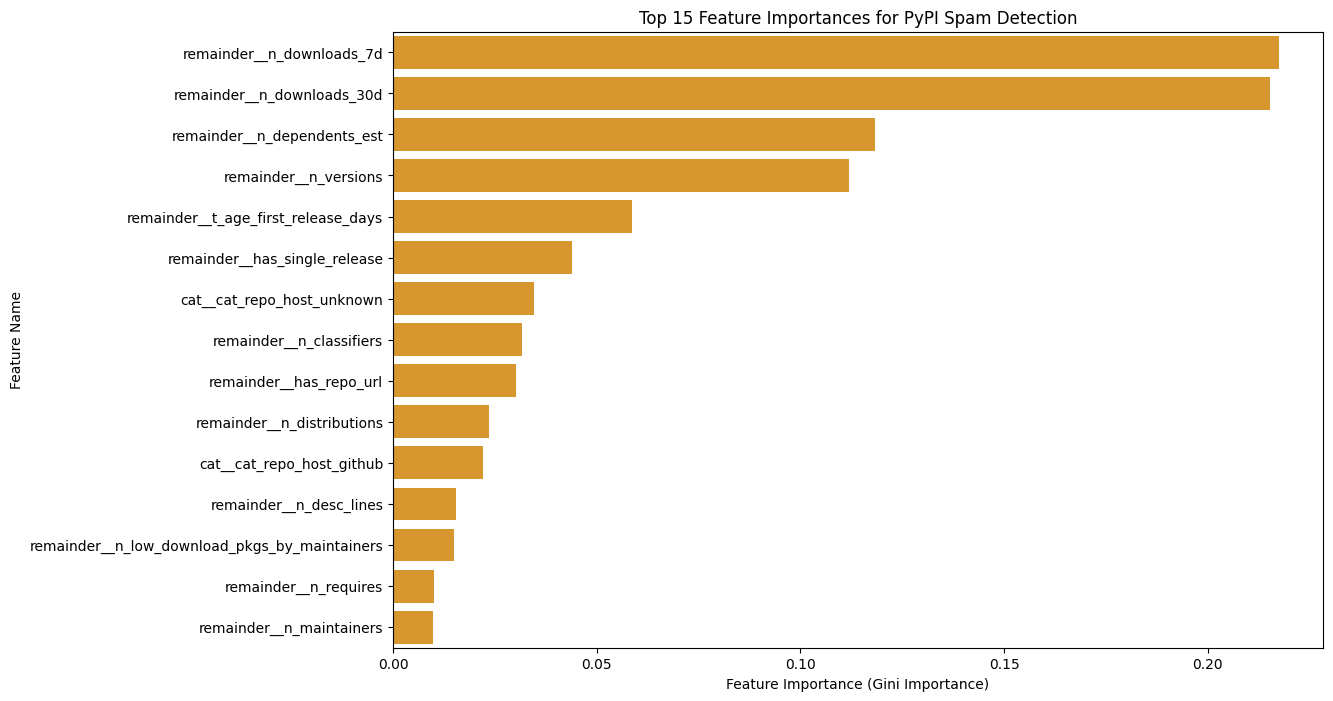

In [15]:
# The list of feature names used for training
# We assume the 'const' term is the first column as added by statsmodels.api.add_constant
feature_names = ["const"] + preprocessor.get_feature_names_out().tolist()

# 2. Extract importances from the fitted model
importances = rf_final.feature_importances_

# 3. Create the DataFrame
feature_importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
)

# 4. Sort and Display Results
# Drop the 'const' feature as its importance is irrelevant/misleading
feature_importance_df = feature_importance_df[
    feature_importance_df["Feature"] != "const"
]

feature_importance_df = feature_importance_df.sort_values(
    by="Importance", ascending=False
).reset_index(drop=True)

print("\n--- Top 15 Feature Importances (Random Forest) ---")
print(feature_importance_df.head(15).to_markdown(index=False))

# 5. Visualization
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)
sns.barplot(x="Importance", y="Feature", data=top_features, color="#f39c12")
plt.title("Top 15 Feature Importances for PyPI Spam Detection")
plt.xlabel("Feature Importance (Gini Importance)")
plt.ylabel("Feature Name")
plt.show()

##### 2.1.5 Gradient Boosting
[Click here to go to 'Quick Summary'](#quick-summary)

In [16]:
gb = GradientBoostingClassifier(random_state=42)

param_dist = {
    "n_estimators": randint(50, 300),  # fewer trees, usually 100–200 is enough
    "learning_rate": uniform(0.01, 0.2),  # narrower, realistic range
    "max_depth": randint(2, 5),  # shallow trees work best for GB
}


gb_random = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist,
    n_iter=50,  # number of random trials. canmake it 30 for random search later.
    scoring="accuracy",
    cv=5,
    random_state=42,
    verbose=2,
)

gb_random.fit(X_train_const, y_train)

# --------------------------------------
# Best params and model
# --------------------------------------
print("\nBest Params:")
print(gb_random.best_params_)

print("\nBest CV Score:", gb_random.best_score_)

# Best model object:
gb_best_model = gb_random.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.0849080237694725, max_depth=2, n_estimators=64; total time=   1.6s
[CV] END learning_rate=0.0849080237694725, max_depth=2, n_estimators=64; total time=   1.5s
[CV] END learning_rate=0.0849080237694725, max_depth=2, n_estimators=64; total time=   1.4s
[CV] END learning_rate=0.0849080237694725, max_depth=2, n_estimators=64; total time=   1.3s
[CV] END learning_rate=0.0849080237694725, max_depth=2, n_estimators=64; total time=   0.9s
[CV] END learning_rate=0.15639878836228102, max_depth=2, n_estimators=70; total time=   1.5s
[CV] END learning_rate=0.15639878836228102, max_depth=2, n_estimators=70; total time=   1.4s
[CV] END learning_rate=0.15639878836228102, max_depth=2, n_estimators=70; total time=   1.4s
[CV] END learning_rate=0.15639878836228102, max_depth=2, n_estimators=70; total time=   1.4s
[CV] END learning_rate=0.15639878836228102, max_depth=2, n_estimators=70; total time=   0.8s
[CV] END lear

In [19]:
# -------------------------------------------
# Extract best hyperparameters from CV
# -------------------------------------------
best_params = gb_best_model.get_params()
learning_rate = best_params.get("learning_rate", 0.1)
n_estimators = best_params.get("n_estimators", 100)
max_depth = best_params.get("max_depth", 3)

# -------------------------------------------
# Fit final Gradient Boosting model
# -------------------------------------------
gb_final = GradientBoostingClassifier(
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    max_depth=max_depth,
    random_state=42,
)

gb_final.fit(X_train_const, y_train)

# Predictions
y_train_pred_gb = gb_final.predict(X_train_const)
y_test_pred_gb = gb_final.predict(X_test_const)

# -------------------------------------------
# Evaluate model
# -------------------------------------------
train_accuracy_gb = accuracy_score(y_train, y_train_pred_gb)
test_accuracy_gb = accuracy_score(y_test, y_test_pred_gb)

print(f"Training Accuracy: {train_accuracy_gb:.4f}")
print(f"Testing Accuracy:  {test_accuracy_gb:.4f}")

print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_test_pred_gb))

# -------------------------------------------
# ROC & AUC
# -------------------------------------------
y_test_proba_gb = gb_final.predict_proba(X_test_const)[:, 1]

fpr_gb, tpr_gb, thresh_gb = roc_curve(y_test, y_test_proba_gb)
auc_gb = roc_auc_score(y_test, y_test_proba_gb)

print(f"AUC-ROC (GB): {auc_gb:.4f}")


Training Accuracy: 1.0000
Testing Accuracy:  0.9997

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       945
           1       1.00      1.00      1.00      2173

    accuracy                           1.00      3118
   macro avg       1.00      1.00      1.00      3118
weighted avg       1.00      1.00      1.00      3118

AUC-ROC (GB): 1.0000


### 2.2 Comparison of Classifiers
#### 2.2.1 Comparison Table 
[Click here to go to 'Quick Summary'](#quick-summary)

In [23]:
import pandas as pd
from sklearn.metrics import recall_score, accuracy_score, roc_auc_score
import numpy as np


def structure_model_metrics(
    y_train_true, y_test_true, y_train_pred, y_test_pred, train_acc, test_acc, auc_score
):
    """Calculates and structures key classification metrics for the positive class (1)."""

    # Calculate Recall for the positive class (Class 1) for both train and test
    recall_train = recall_score(
        y_train_true, y_train_pred, pos_label=1, zero_division=0
    )
    recall_test = recall_score(y_test_true, y_test_pred, pos_label=1, zero_division=0)

    return {
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc,
        "Train Recall (Class 1)": recall_train,
        "Test Recall (Class 1)": recall_test,
        "Test AUC": auc_score,
    }


# --- 2. Calculate Metrics for Each Model ---

# A. Logistic Regression Metrics
logreg_metrics = structure_model_metrics(
    y_train,
    y_test,
    y_train_pred_log,
    y_test_pred_log,
    train_accuracy_log,
    test_accuracy_log,
    auc_log,
)

# B. SVM Classifier Metrics
svm_metrics = structure_model_metrics(
    y_train,
    y_test,
    y_train_pred_svm,
    y_test_pred_svm,
    train_accuracy_svm,
    test_accuracy_svm,
    auc_svm,
)

# C. Decision Tree Metrics
# NOTE: The AUC for DTC uses y_test_proba_dtc (probabilities), which is the standard,
# while the other predictions use classes, which is fine for direct comparison.
dtc_metrics = structure_model_metrics(
    y_train,
    y_test,
    y_train_pred_dtc,
    y_test_pred_dtc,
    train_accuracy_dtc,
    test_accuracy_dtc,
    auc_dtc,
)

# D. Random Forest
dtc_metrics = structure_model_metrics(
    y_train,
    y_test,
    y_train_pred_rf,
    y_test_pred_rf,
    train_accuracy_rf,
    test_accuracy_rf,
    auc_rf,
)

# D. Random Forest
rf_metrics = structure_model_metrics(
    y_train,
    y_test,
    y_train_pred_rf,
    y_test_pred_rf,
    train_accuracy_rf,
    test_accuracy_rf,
    auc_rf,
)

placeholder_metrics = {
    "Train Accuracy": np.nan,
    "Test Accuracy": np.nan,
    "Train Recall (Class 1)": np.nan,
    "Test Recall (Class 1)": np.nan,
    "Test AUC": np.nan,
}

# --- 3. Consolidate into the Final DataFrame ---
all_results = {
    "Logistic Regression": logreg_metrics,
    "SVM Classifier": svm_metrics,
    "Decision Tree": dtc_metrics,
    "Random Forest": rf_metrics,
    # "Gradient Boosting": placeholder_metrics,
}

results_df = pd.DataFrame(all_results).T

# --- 4. Display the Formatted Table ---
print(
    "----------------------------------------------------\n--- CONSOLIDATED CLASSIFICATION MODEL COMPARISON ---"
)

# Format all columns to 3 decimal places
results_df_formatted = results_df.applymap(lambda x: f"{x:.3f}" if pd.notna(x) else "-")

# Print the final comparison table
# print(results_df_formatted.to_markdown(index=True))
results_df_formatted

----------------------------------------------------
--- CONSOLIDATED CLASSIFICATION MODEL COMPARISON ---


,Train Accuracy,Test Accuracy,Train Recall (Class 1),Test Recall (Class 1),Test AUC
Logistic Regression,0.989,0.987,0.994,0.989,0.985
SVM Classifier,0.991,0.990,0.995,0.993,0.989
Decision Tree,0.989,0.987,1.000,1.000,1.000
Random Forest,0.989,0.987,1.000,1.000,1.000


##### 2.2.2 Comparison ROC curve
[Click here to go to 'Quick Summary'](#quick-summary)

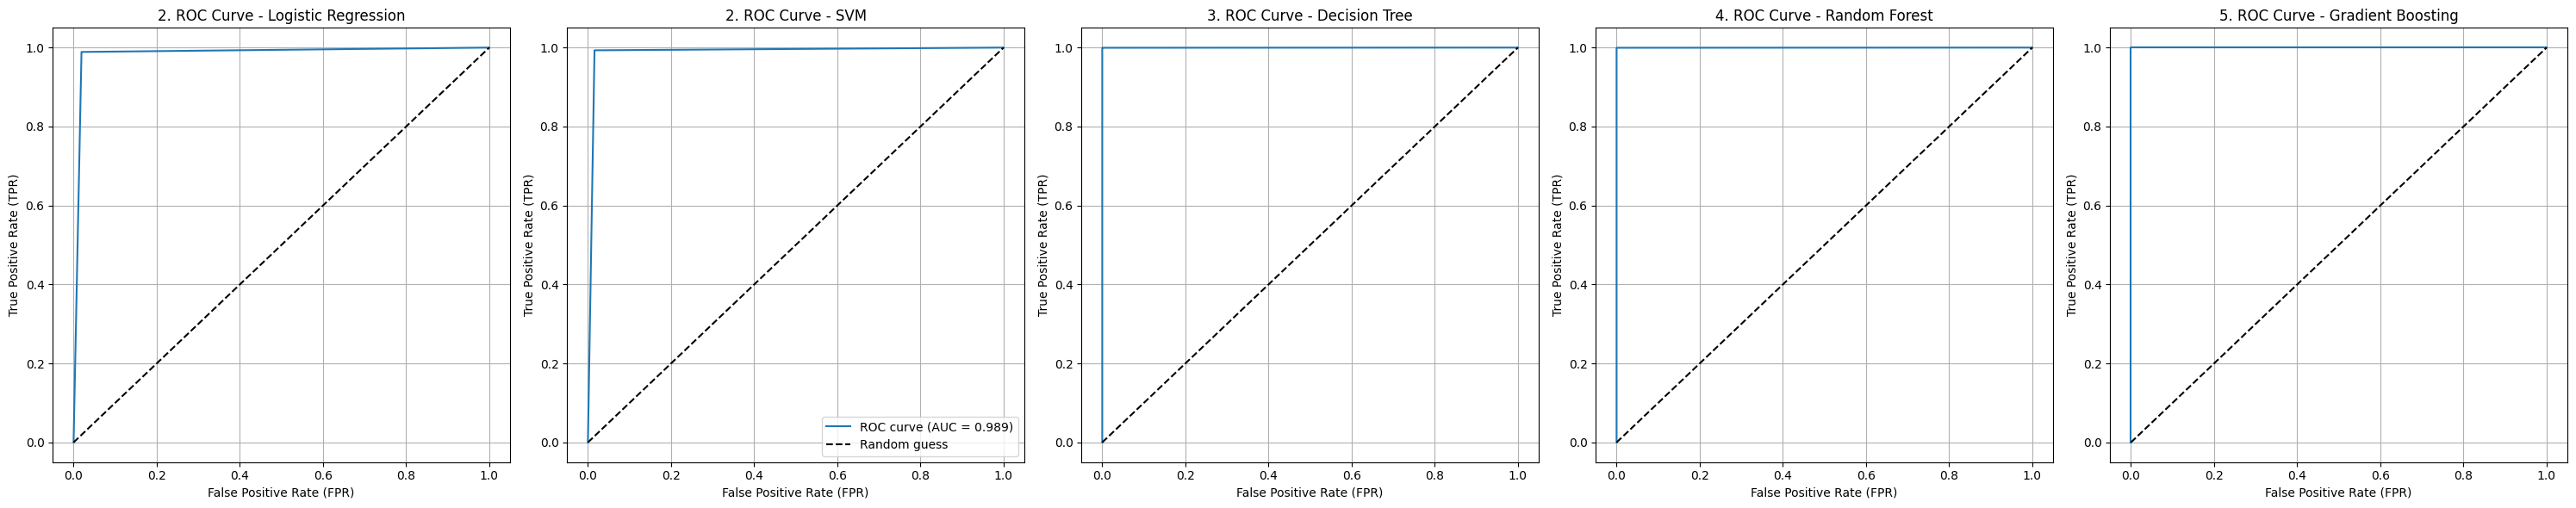

In [24]:
# 2. Comparison Graph:
# --- Setup for Multiple Plots ---
fig, axes = plt.subplots(1, 5, figsize=(30, 6))

# Ensure axes is flat for easy iteration
axes = axes.flatten()

# --- Plot 1: Logistic Regression ---
ax = axes[0]
ax.plot(fpr_log, tpr_log, label=f"ROC curve (AUC = {auc_log:.3f})")
ax.plot([0, 1], [0, 1], "k--", label="Random guess")
ax.set_xlabel("False Positive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
ax.set_title("2. ROC Curve - Logistic Regression")
ax.grid(True)

# --- Plot 1: SVM ROC Curve ---
ax = axes[1]
ax.plot(fpr_svm, tpr_svm, label=f"ROC curve (AUC = {auc_svm:.3f})")
ax.plot([0, 1], [0, 1], "k--", label="Random guess")
ax.set_xlabel("False Positive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
ax.set_title("2. ROC Curve - SVM")
ax.legend(loc="lower right")
ax.grid(True)

# --- Plot 3:  ---
ax = axes[2]
ax.set_title("3. ROC Curve - Decision Tree")
ax.plot(fpr_dtc, tpr_dtc, label=f"ROC curve (AUC = {auc_dtc:.3f})")
ax.plot([0, 1], [0, 1], "k--", label="Random guess")
ax.set_xlabel("False Positive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
ax.grid(True)

# --- Plot 4: ---
ax = axes[3]
ax.set_title("4. ROC Curve - Random Forest")
ax.plot(fpr_rf, tpr_rf, label=f"ROC curve (AUC = {auc_rf:.3f})")
ax.plot([0, 1], [0, 1], "k--", label="Random guess")
ax.set_xlabel("False Positive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
ax.grid(True)

# --- Plot 5: ---
ax = axes[4]
ax.set_title("5. ROC Curve - Gradient Boosting")
ax.plot(fpr_gb, tpr_gb, label=f"ROC curve (AUC = {auc_gb:.3f})")
ax.plot([0, 1], [0, 1], "k--", label="Random guess")
ax.set_xlabel("False Positive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
ax.grid(True)

# --- Final Display ---
plt.tight_layout()
plt.show()

### 3. Model Extraction

[Click here to go to 'Quick Summary'](#quick-summary)

In [ ]:
from datetime import datetime
from pathlib import Path

# Create models directory and generate timestamp
models_dir = Path("../models")
models_dir.mkdir(exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

def save_model(model, base_name, models_dir, timestamp):
    """Save model with timestamp to models directory."""
    filename = f"{base_name}_{timestamp}.joblib"
    filepath = models_dir / filename
    joblib.dump(model, filepath)
    # Also save as the 'latest' version without timestamp
    latest_filepath = models_dir / f"{base_name}.joblib"
    joblib.dump(model, latest_filepath)
    print(f"Saved: {filepath} (and {latest_filepath})")
    return filepath

# Save preprocessor and scaler
save_model(preprocessor, "fitted_preprocessor", models_dir, timestamp)
save_model(scaler, "fitted_scaler", models_dir, timestamp)

# Save all classifier models
save_model(log_reg_base, "log_reg_spam_classifier", models_dir, timestamp)
save_model(svm_model, "svm_linear_spam_classifier", models_dir, timestamp)
save_model(dtc_best_model, "dtc_spam_classifier", models_dir, timestamp)
save_model(rf_final, "rf_spam_classifier", models_dir, timestamp)
save_model(gb_final, "gb_spam_classifier", models_dir, timestamp)

print(f"\nAll models saved with timestamp: {timestamp}")
